<a href="https://colab.research.google.com/github/Bright-Momo/SimplifiedJournalsGame/blob/main/Replicator_dynamics_differentinitial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

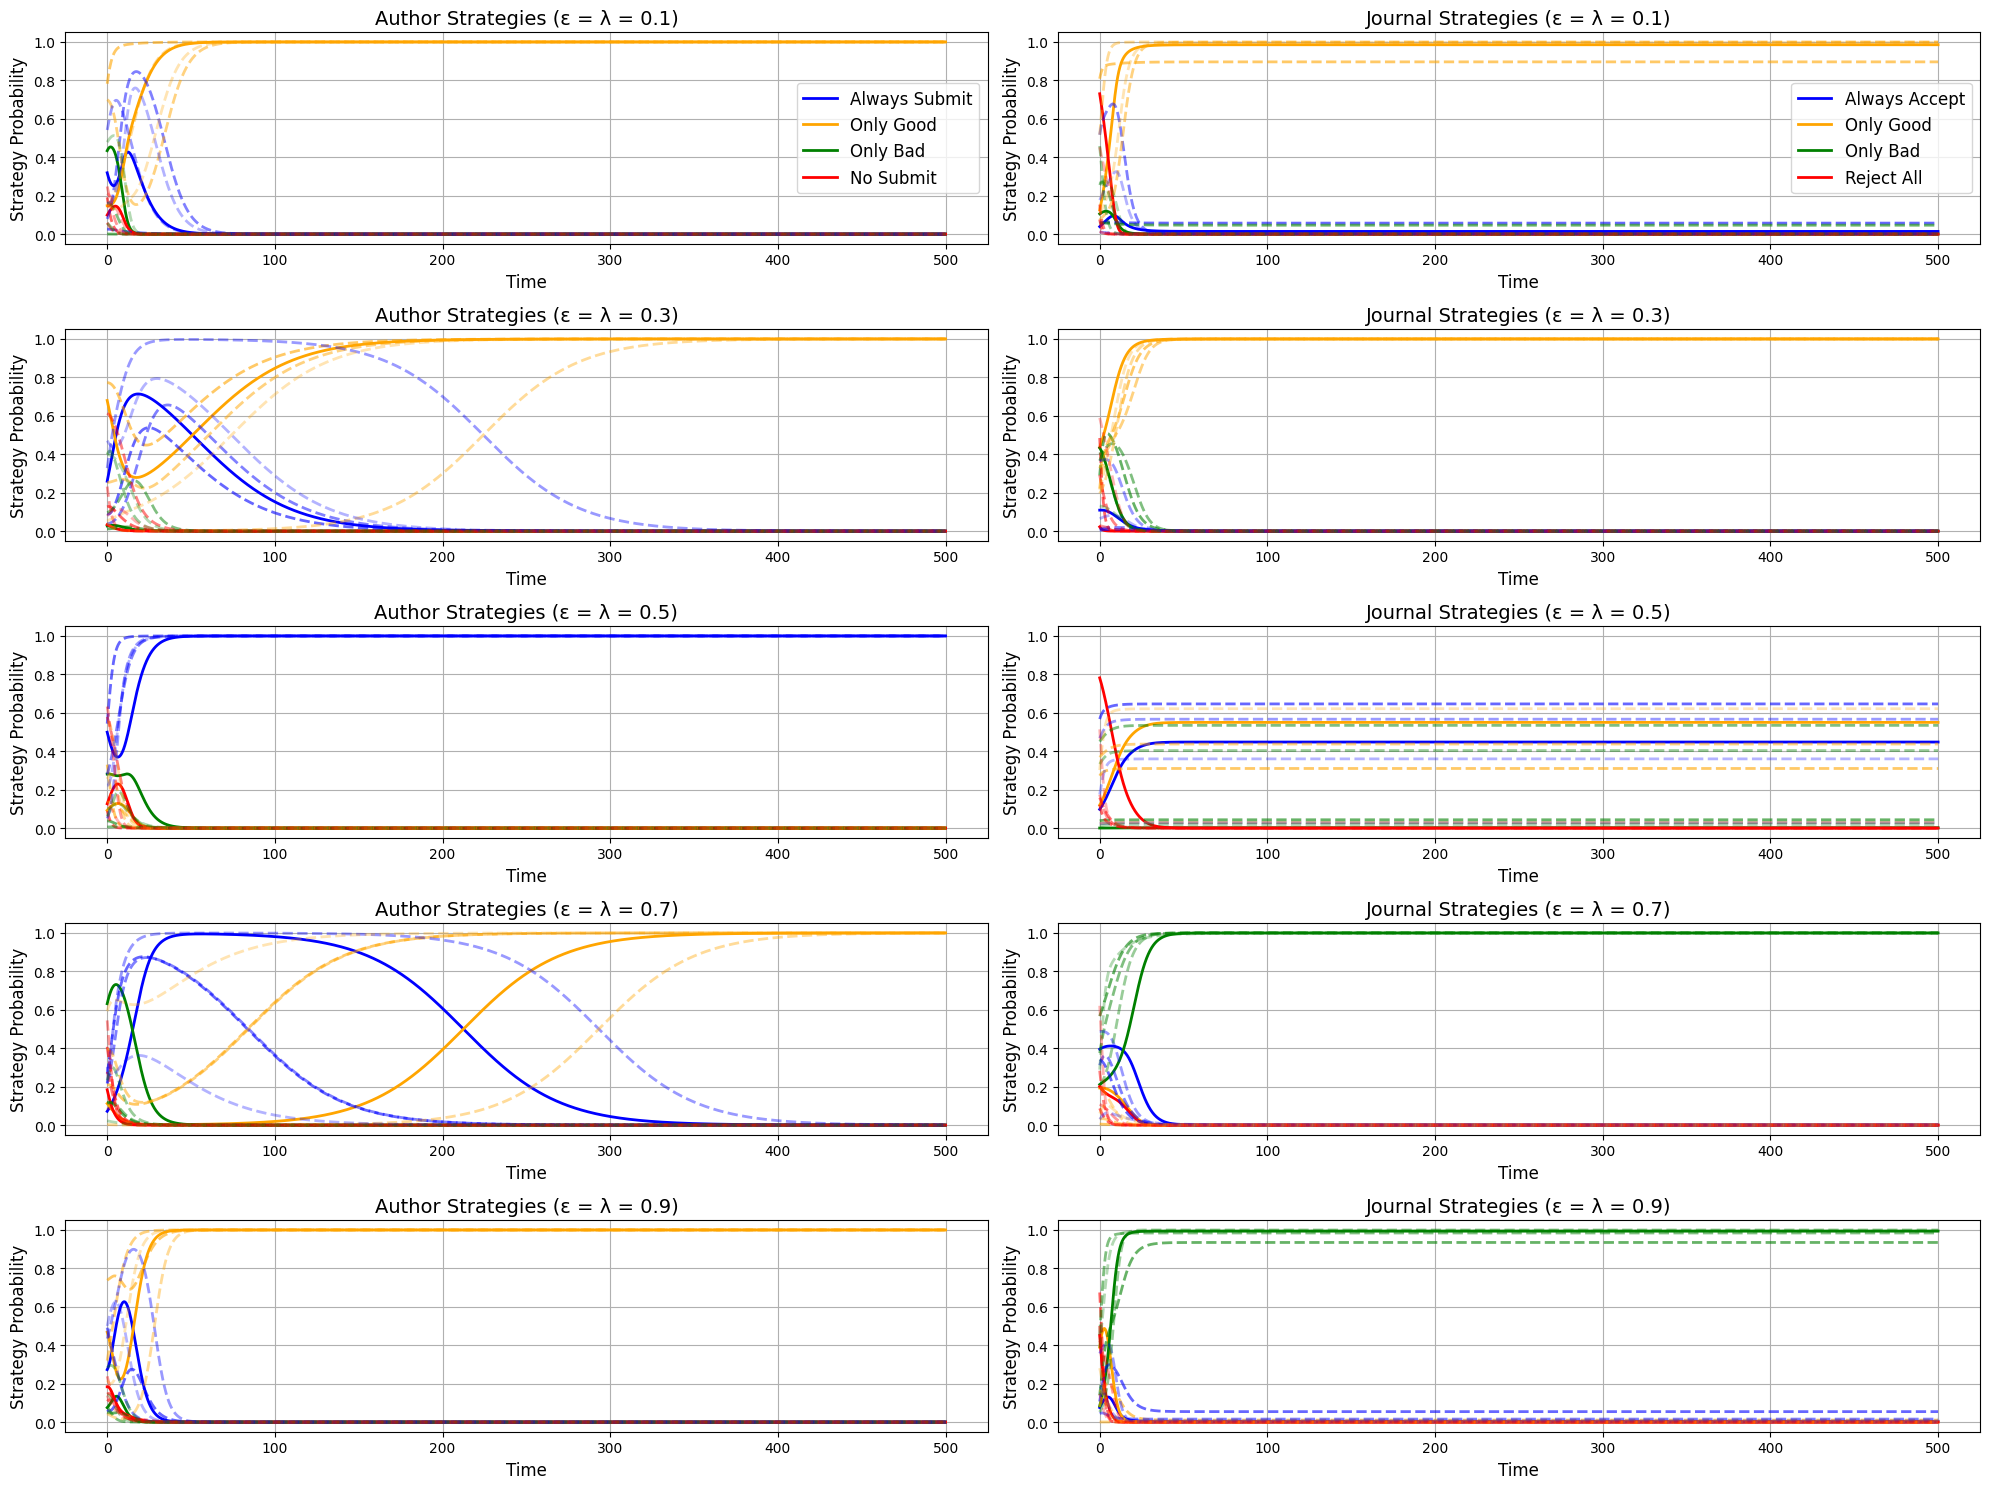

In [6]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Parameters (constant)
alpha = 0.6    # Probability of a good paper
r = 1.0        # Reward for author when accepted
c = 0.5        # Cost for author when rejected
gamma = 0.1    # Cost for journal when reviewing a paper

def acceptance_probability(is_good_paper, journal_strategy, epsilon, lam):
    if journal_strategy == 0:  # Always Accept
        return 1.0
    elif journal_strategy == 1:  # Only Accept Good
        return 1 - epsilon if is_good_paper else lam
    elif journal_strategy == 2:  # Only Accept Bad
        return epsilon if is_good_paper else 1 - lam
    else:  # Reject All
        return 0.0

def author_journal_payoff(author_strategy, journal_strategy, epsilon, lam):
    if author_strategy == 0:
        good_prob, bad_prob = alpha, 1 - alpha
    elif author_strategy == 1:
        good_prob, bad_prob = alpha, 0
    elif author_strategy == 2:
        good_prob, bad_prob = 0, 1 - alpha
    else:
        good_prob, bad_prob = 0, 0

    p_accept_good = acceptance_probability(True, journal_strategy, epsilon, lam)
    p_accept_bad = acceptance_probability(False, journal_strategy, epsilon, lam)

    accept_rate = good_prob * p_accept_good + bad_prob * p_accept_bad
    submit_rate = good_prob + bad_prob
    reject_rate = submit_rate - accept_rate

    author_payoff = accept_rate * r - reject_rate * c

    # Payoff equation
    if accept_rate > 0:
        journal_payoff = (good_prob * p_accept_good) / accept_rate - gamma * submit_rate
    else:
        journal_payoff = 0  # pay nothing if no receive paper

    return author_payoff, journal_payoff

def build_payoff_matrices(epsilon, lam):
    num_strategies = 4

    # Initialize payoff matrices
    author_payoff_matrix = np.zeros((num_strategies, num_strategies))
    journal_payoff_matrix = np.zeros((num_strategies, num_strategies))

    # Calculate payoffs for all strategy combinations
    for i in range(num_strategies):
        for j in range(num_strategies):
            author_pay, journal_pay = author_journal_payoff(i, j, epsilon, lam)
            author_payoff_matrix[i, j] = author_pay
            journal_payoff_matrix[i, j] = journal_pay

    return author_payoff_matrix, journal_payoff_matrix

def replicator_dynamics(y, t, author_matrix, journal_matrix):
    # Strategy frequencies
    author_freqs = y[:4]
    journal_freqs = y[4:]

    # Frequencies are valid
    author_freqs = np.clip(author_freqs, 0, 1)
    journal_freqs = np.clip(journal_freqs, 0, 1)

    # Sum equals 1
    author_freqs = author_freqs / np.sum(author_freqs)
    journal_freqs = journal_freqs / np.sum(journal_freqs)

    # Expected payoffs for each strategy
    author_expected_payoffs = np.dot(author_matrix, journal_freqs)
    journal_expected_payoffs = np.dot(author_freqs, journal_matrix)

    # Average payoffs
    avg_author_payoff = np.dot(author_freqs, author_expected_payoffs)
    avg_journal_payoff = np.dot(journal_freqs, journal_expected_payoffs)

    # Replicator equation
    author_derivs = author_freqs * (author_expected_payoffs - avg_author_payoff)
    journal_derivs = journal_freqs * (journal_expected_payoffs - avg_journal_payoff)

    # Combine derivatives and return
    return np.concatenate([author_derivs, journal_derivs])

# Selected error rates to analyze
error_rates = [0.1, 0.3, 0.5, 0.7, 0.9]

# Number of random initial conditions to test for each error rate
num_trials = 5

# Time points for simulation
t = np.arange(0, 500.1, 0.1)  # Time from 0 to 100 with step 0.1

# Strategy names for visualization
author_names = ["Always Submit", "Only Good", "Only Bad", "No Submit"]
journal_names = ["Always Accept", "Only Good", "Only Bad", "Reject All"]

# Create figure
plt.figure(figsize=(20, 15))
gs = GridSpec(len(error_rates), 2)

# For each error rate, simulate dynamics with different random initial conditions
for i, error_rate in enumerate(error_rates):
    # Build payoff matrices
    author_matrix, journal_matrix = build_payoff_matrices(error_rate, error_rate)

    # Create subplot for author strategies
    ax1 = plt.subplot(gs[i, 0])
    ax1.set_title(f'Author Strategies (ε = λ = {error_rate})', fontsize=14)
    ax1.set_xlabel('Time', fontsize=12)
    ax1.set_ylabel('Strategy Probability', fontsize=12)
    ax1.set_ylim(-0.05, 1.05)
    ax1.grid(True)

    # Create subplot for journal strategies
    ax2 = plt.subplot(gs[i, 1])
    ax2.set_title(f'Journal Strategies (ε = λ = {error_rate})', fontsize=14)
    ax2.set_xlabel('Time', fontsize=12)
    ax2.set_ylabel('Strategy Probability', fontsize=12)
    ax2.set_ylim(-0.05, 1.05)
    ax2.grid(True)

    # Colors for strategies
    colors = ['blue', 'orange', 'green', 'red']

    # Run simulations with different random initial conditions
    for trial in range(num_trials):
        # Generate random initial strategy frequencies using Dirichlet distribution
        # Alpha=1 creates a uniform distribution over the simplex (all frequencies sum to 1)
        author_initial = np.random.dirichlet(np.ones(4))
        journal_initial = np.random.dirichlet(np.ones(4))

        # Combine into initial state vector
        initial_freqs = np.concatenate([author_initial, journal_initial])

        # Solve dynamics
        solution = odeint(replicator_dynamics, initial_freqs, t, args=(author_matrix, journal_matrix))

        # Extract author and journal strategies over time
        author_strategies = solution[:, :4]
        journal_strategies = solution[:, 4:]

        # Plot author strategies for this trial
        for j in range(4):
            # Use solid line for first trial, dashed lines for others
            linestyle = '-' if trial == 0 else '--'
            alpha = 1.0 if trial == 0 else 0.7 - trial * 0.1  # Decrease opacity for later trials
            ax1.plot(t, author_strategies[:, j], color=colors[j], linestyle=linestyle,
                    alpha=alpha, linewidth=2, label=author_names[j] if trial == 0 else "")

        # Plot journal strategies for this trial
        for j in range(4):
            linestyle = '-' if trial == 0 else '--'
            alpha = 1.0 if trial == 0 else 0.7 - trial * 0.1
            ax2.plot(t, journal_strategies[:, j], color=colors[j], linestyle=linestyle,
                    alpha=alpha, linewidth=2, label=journal_names[j] if trial == 0 else "")

    # Add legend to first row only
    if i == 0:
        ax1.legend(fontsize=12)
        ax2.legend(fontsize=12)

plt.tight_layout()
plt.show()









